# Xây dựng RFM cho phân tích giá trị khách hàng

Recency: khoảng thời gian giữa ngày hiện tại xét và ngày mua cuối cùng của mỗi khách hàng, sau đó quyết định các khoảng của nó
Frequecy: tổng số lần khách hàng mua. Ta sử dụng quantile khách hàng vào các loại khác nhau hoặc phân tách chúng bởi các quy tắ định nghĩa trước
Monetary: tổng hoặc trung bình số tiền mua của khách hàng.

## Đọc dữ liệu

Tập dữ liệu giao dịch chứa tất cả các giao dịch xảy ra giữa ngày 01/12/2010 và 09/12/2011 của một cửa hàng bán lẻ qua mạng.

In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()

In [3]:
retail_df = pd.read_excel('_data/Online Retail.xlsx')

In [4]:
retail_df['InvoiceDate_date']=retail_df.InvoiceDate.map(lambda x: x.strftime('%Y-%m-%d'))
retail_df['InvoiceDate_YearMonth']=retail_df.InvoiceDate.map(lambda x: x.strftime('%Y-%m'))

In [5]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_date,InvoiceDate_YearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12


In [6]:
retail_df = retail_df[(retail_df.CustomerID.notnull()) & (retail_df.Quantity>0)]
retail_df['CustomerID'] = retail_df['CustomerID'].apply(int).apply(str)

## Phân tích dữ liệu

##### Thông kê mô tả

In [7]:
retail_df.shape

(397924, 10)

In [8]:
retail_df.describe()

,Quantity,UnitPrice
count,397924.000000,397924.000000
mean,13.021823,3.116174
std,180.420210,22.096788
min,1.000000,0.000000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [9]:
retail_df.InvoiceDate.describe()

count                  397924
unique                  17286
top       2011-11-14 15:27:00
freq                      542
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

##### Thống kê số lượng tài khoản giao dịch của mỗi quốc gia

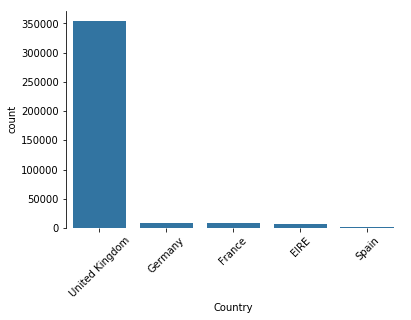

In [10]:
country_count=sns.countplot(x="Country", data=retail_df, color=color[0],order=retail_df.Country.value_counts().iloc[0:5,].index);
plt.setp(country_count.get_xticklabels(), rotation=45)
sns.despine(bottom=True)

##### Thống kê số lượng đơn đặt hàng mỗi tháng

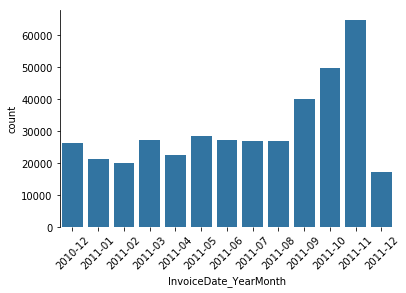

In [11]:
month_plot=sns.countplot(x="InvoiceDate_YearMonth", data=retail_df, color=color[0]);
plt.setp(month_plot.get_xticklabels(), rotation=45)
sns.despine(bottom=True)

##### Thống kê các mặt hàng phổ biến

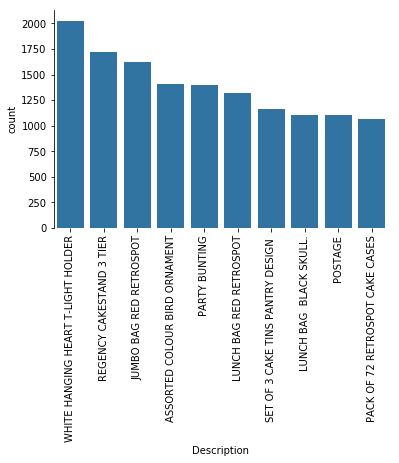

In [12]:
item_plot=sns.countplot(x="Description", data=retail_df, color=color[0],order=retail_df.Description.value_counts().iloc[0:10,].index);
plt.setp(item_plot.get_xticklabels(), rotation=90);
sns.despine(bottom=True)

### Tính R

Định nghĩa Recency có giá trị bằng 5 nếu khách hàng có đơn đặt hàng cuối cùng gần nhất là 0 đến 2 tháng, 4 là 2 đến 4 tháng, 3 là 4 đến 6 tháng, 2 là 6 đến 8 tháng và 1 là nhiều hơn 8 tháng.

In [13]:
from pandas.tseries.offsets import *

Mỗi khách hàng sẽ lấy ngày hóa đơn cuối cùng để xác định Recency

In [14]:
customer_df = pd.DataFrame(retail_df.groupby('CustomerID')['InvoiceDate'].max()).reset_index()
customer_df.head()

,CustomerID,InvoiceDate
0,12346,2011-01-18 10:01:00
1,12347,2011-12-07 15:52:00
2,12348,2011-09-25 13:13:00
3,12349,2011-11-21 09:51:00
4,12350,2011-02-02 16:01:00


In [15]:
def recency(row):
    last_day=pd.Timestamp(2011, 12, 9)
    if row['InvoiceDate'] > last_day + DateOffset(months=-2):
        val = 5
    elif row['InvoiceDate'] <= last_day + DateOffset(months=-2) and row['InvoiceDate'] > last_day + DateOffset(months=-4):
        val = 4
    elif row['InvoiceDate'] <= last_day + DateOffset(months=-4) and row['InvoiceDate'] > last_day + DateOffset(months=-6):
        val = 3
    elif row['InvoiceDate'] <= last_day + DateOffset(months=-6) and row['InvoiceDate'] > last_day + DateOffset(months=-8):
        val = 2
    else:
        val = 1
    return val

Tính giá trị Recency là khoảng thời gian giữa lần mua cuối cùng và thời điểm hiện tại xét (giả sử 9/12/2011)

In [16]:
last_day=pd.Timestamp(2011, 12, 9)
customer_df_ = retail_df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (last_day - x.max()).days})
customer_df_['InvoiceDate'] = customer_df_['InvoiceDate'].astype(int)
customer_df_.rename(columns={'InvoiceDate': 'recency_'},inplace=True)
customer_df_= pd.merge(customer_df_,customer_df[['CustomerID','InvoiceDate']],on='CustomerID', how='left')
customer_df_.head(10)

,CustomerID,recency_,InvoiceDate
0,12346,324,2011-01-18 10:01:00
1,12347,1,2011-12-07 15:52:00
2,12348,74,2011-09-25 13:13:00
3,12349,17,2011-11-21 09:51:00
4,12350,309,2011-02-02 16:01:00
5,12352,35,2011-11-03 14:37:00
6,12353,203,2011-05-19 17:47:00
7,12354,231,2011-04-21 13:11:00
8,12355,213,2011-05-09 13:49:00
9,12356,21,2011-11-17 08:40:00


In [17]:

customer_df_['Recency'] = customer_df_.apply(recency, axis=1)
customer_df_

,CustomerID,recency_,InvoiceDate,Recency
0,12346,324,2011-01-18 10:01:00,1
1,12347,1,2011-12-07 15:52:00,5
2,12348,74,2011-09-25 13:13:00,4
3,12349,17,2011-11-21 09:51:00,5
4,12350,309,2011-02-02 16:01:00,1
5,12352,35,2011-11-03 14:37:00,5
6,12353,203,2011-05-19 17:47:00,2
7,12354,231,2011-04-21 13:11:00,2
8,12355,213,2011-05-09 13:49:00,2
9,12356,21,2011-11-17 08:40:00,5


In [18]:
recency_df = pd.DataFrame(customer_df_.Recency.value_counts()).reset_index().sort_values(by='index', ascending=False)
recency_df

,index,Recency
0,5,2426
1,4,708
3,3,360
4,2,316
2,1,529


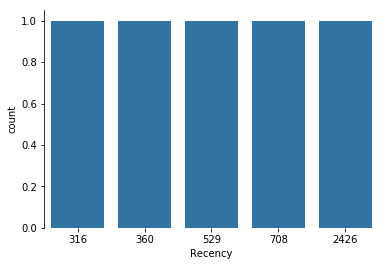

In [49]:
recency_plot=sns.countplot(x="Recency", data=recency_df, color=color[0]);
plt.setp(item_plot.get_xticklabels(), rotation=90);
sns.despine(bottom=True)

In [50]:
final_customer_df = customer_df_[['CustomerID','Recency','recency_']]
#final_customer_df = pd.merge(final_customer_df,customer_df[['CustomerID','Recency_']],on='CustomerID', how='left')
final_customer_df.head()

,CustomerID,Recency,recency_
0,12346,1,324
1,12347,5,1
2,12348,4,74
3,12349,5,17
4,12350,1,309


### Tính F

Định nghĩa Tần suất là "Tổng số đơn đặt hàng cho mỗi người dùng trong vòng 365 ngày gần nhất" thay vì "Tần suất họ mua hàng trong một khoảng thời gian nhất định". Chia giá trị của tổng số đơn đặt hàng của mỗi người dùng vào miền giá trị 5,4,3,2,1 tương ứng.

In [51]:
target_date = str(pd.Timestamp(retail_df.InvoiceDate_date.max())+ DateOffset(months=-12))

frequency_df = pd.DataFrame(retail_df[retail_df.InvoiceDate_date > target_date].groupby('CustomerID')['InvoiceNo'].nunique()
).reset_index()
frequency_df = frequency_df.rename(columns={'InvoiceNo':'Count_'})
frequency_df.head()

,CustomerID,Count_
0,12346,1
1,12347,6
2,12348,4
3,12349,1
4,12350,1


In [54]:
frequency_df['Frequency'] = pd.qcut(frequency_df['Count_'], 7, labels=[1,2,3,4,5],duplicates='drop')
frequency_df

,CustomerID,Count_,Frequency
0,12346,1,1
1,12347,6,4
2,12348,4,3
3,12349,1,1
4,12350,1,1
5,12352,8,5
6,12353,1,1
7,12354,1,1
8,12355,1,1
9,12356,3,2


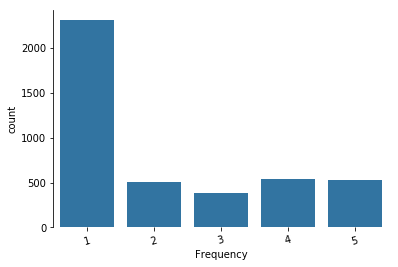

In [23]:
frequency_plot=sns.countplot(x="Frequency", data=frequency_df, color=color[0]);
plt.setp(frequency_plot.get_xticklabels(), rotation=15);
sns.despine(bottom=True)

In [24]:
final_customer_df = pd.merge(final_customer_df,frequency_df[['CustomerID','Frequency']],on='CustomerID', how='left')
final_customer_df.head()

,CustomerID,Recency,recency_,Frequency
0,12346,1,324,1
1,12347,5,1,4
2,12348,4,74,3
3,12349,5,17,1
4,12350,1,309,1


### Tính M

Giá trị monetary được xác định là tổng số tiền mua của mỗi khách hàng trong vòng 1 năm và lấy quantile tương ứng với miền giá trị 5,4,3,2,1.

In [25]:
retail_df['total_price']=retail_df['Quantity'] * retail_df['UnitPrice']

In [26]:
target_date = str(pd.Timestamp(retail_df.InvoiceDate_date.max())+ DateOffset(months=-12))

monetary_df = pd.DataFrame(retail_df[retail_df.InvoiceDate_date > target_date].groupby('CustomerID')['total_price'].agg('sum')
).reset_index()
monetary_df.head()

,CustomerID,total_price
0,12346,77183.60
1,12347,3598.21
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


In [27]:
monetary_df['Monetary'] = pd.qcut(monetary_df['total_price'], 5, labels=[1,2,3,4,5])

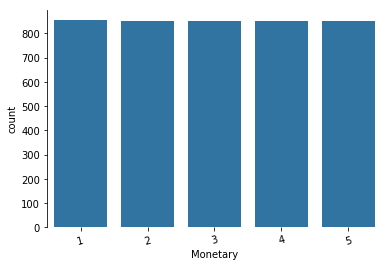

In [28]:
monetary_plot=sns.countplot(x="Monetary", data=monetary_df, color=color[0]);
plt.setp(monetary_plot.get_xticklabels(), rotation=15);
sns.despine(bottom=True)

In [29]:
final_customer_df = pd.merge(final_customer_df,monetary_df[['CustomerID','Monetary']],on='CustomerID', how='left')
#final_customer_df = pd.merge(final_customer_df,monetary_df[['CustomerID','total_price']],on='CustomerID', how='left')
#final_customer_df = pd.merge(final_customer_df,frequency_df[['CustomerID','Count_']],on='CustomerID', how='left')

In [30]:
final_customer_df = pd.merge(final_customer_df,monetary_df[['CustomerID','total_price']],on='CustomerID', how='left')

In [31]:
final_customer_df = pd.merge(final_customer_df,frequency_df[['CustomerID','Count_']],on='CustomerID', how='left')

### Xây dựng giá trị RFM

Giá trị RFM được xác định là việc kết hợp (nối) 3 giá trị R, F, M.

In [32]:
final_customer_df.head()

,CustomerID,Recency,recency_,Frequency,Monetary,total_price,Count_
0,12346,1,324,1,5,77183.60,1.0
1,12347,5,1,4,5,3598.21,6.0
2,12348,4,74,3,4,1797.24,4.0
3,12349,5,17,1,4,1757.55,1.0
4,12350,1,309,1,2,334.40,1.0


In [33]:
final_customer_df['Recency'] = final_customer_df['Recency'].apply(int).apply(str)
final_customer_df['Frequency'] = final_customer_df['Frequency'].apply(int).apply(str)
final_customer_df['Monetary'] = final_customer_df['Monetary'].apply(int).apply(str)

In [34]:
final_customer_df['RFM'] = final_customer_df[['Recency','Frequency','Monetary']].apply(lambda x : '{}{}{}'.format(x[0],x[1],x[2]), axis=1)

In [35]:

final_customer_df.head()

,CustomerID,Recency,recency_,Frequency,Monetary,total_price,Count_,RFM
0,12346,1,324,1,5,77183.60,1.0,115
1,12347,5,1,4,5,3598.21,6.0,545
2,12348,4,74,3,4,1797.24,4.0,434
3,12349,5,17,1,4,1757.55,1.0,514
4,12350,1,309,1,2,334.40,1.0,112


### Phân nhóm khách hàng dựa trên giá trị RFM

In [36]:
final_customer_df=final_customer_df.dropna()
final_customer_df=final_customer_df.reset_index()

from sklearn.preprocessing import LabelEncoder 
from sklearn import preprocessing
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
#we will normalize our data so the prediction on all features will be at the same scale
X = final_customer_df.iloc[:,[2,4,5]].values
#from sklearn import preprocessing  
X_train = preprocessing.MinMaxScaler().fit_transform(X)
X

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


array([['1', '1', '5'],
       ['5', '4', '5'],
       ['4', '3', '4'],
       ...,
       ['5', '1', '1'],
       ['5', '5', '5'],
       ['5', '2', '4']], dtype=object)

#### Xác định số nhóm k tối ưu bằng phương pháp elbow.

In [37]:
#Kmeans k = 1,2,...,11
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

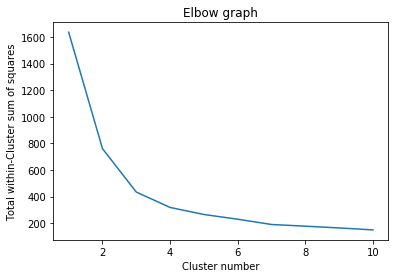

In [38]:
#elbow find k clusters optimal
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('Total within-Cluster sum of squares')
plt.show()

In [39]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(X_train)
kmeans_4 = kmeans.inertia_
centroids = kmeans.cluster_centers_
centroids

array([[0.89208333, 0.19791667, 0.63708333],
       [0.92616721, 0.02850163, 0.13680782],
       [0.2020751 , 0.02618577, 0.21541502],
       [0.96113074, 0.85114841, 0.90437279]])

In [40]:
kmeans_1 = KMeans(n_clusters=1, init='k-means++', random_state=0)
clusters_1 = kmeans_1.fit_predict(X_train)
kmeans_1 = kmeans_1.inertia_

#### Đánh giá độ chính xác của mô hình phân nhóm.

In [41]:
espsilon = kmeans_4/kmeans_1
Accuracy = 1 - espsilon
print("Accuracy Kmeans: %.2f" %Accuracy)

Accuracy Kmeans: 0.81


In [42]:
#show clusters of object
final_customer_df['clusters'] = clusters
final_customer_df.head(4000)

,index,CustomerID,Recency,recency_,Frequency,Monetary,total_price,Count_,RFM,clusters
0,0,12346,1,324,1,5,77183.60,1.0,115,2
1,1,12347,5,1,4,5,3598.21,6.0,545,3
2,2,12348,4,74,3,4,1797.24,4.0,434,0
3,3,12349,5,17,1,4,1757.55,1.0,514,0
4,4,12350,1,309,1,2,334.40,1.0,112,2
5,5,12352,5,35,5,5,2506.04,8.0,555,3
6,6,12353,2,203,1,1,89.00,1.0,211,2
7,7,12354,2,231,1,4,1079.40,1.0,214,2
8,8,12355,2,213,1,2,459.40,1.0,212,2
9,9,12356,5,21,2,5,2811.43,3.0,525,0


#### Xếp hạng (Ranking) khách hàng dựa trên giá trị tổng số tiền mua.

In [43]:
customers_rank = final_customer_df
# Create a new column that is the rank of the value of coverage in ascending order
customers_rank['Rank'] = customers_rank['total_price'].rank(ascending=0)
#customers_rank.drop('RevenueRank',axis=1,inplace=True)
customers_rank.sort_values('Rank',ascending=True)

,index,CustomerID,Recency,recency_,Frequency,Monetary,total_price,Count_,RFM,clusters,Rank
1668,1690,14646,5,0,5,5,280206.02,74.0,555,3,1.0
4131,4202,18102,5,-1,5,5,231822.69,56.0,555,3,2.0
3672,3729,17450,5,7,5,5,192521.95,44.0,555,3,3.0
2964,3009,16446,5,-1,1,5,168472.50,2.0,515,0,4.0
1855,1880,14911,5,0,5,5,139413.48,193.0,555,3,5.0
55,55,12415,5,23,5,5,124914.53,21.0,555,3,6.0
1317,1334,14156,5,8,5,5,117057.43,54.0,555,3,7.0
3714,3772,17511,5,1,5,5,87591.70,29.0,555,3,8.0
0,0,12346,1,324,1,5,77183.60,1.0,115,2,9.0
2662,2703,16029,5,37,5,5,76753.32,60.0,555,3,10.0


#### Thống kê và visualization giá trị RFM của mỗi nhóm

Counter({0: 1200, 3: 1132, 2: 1012, 1: 921})


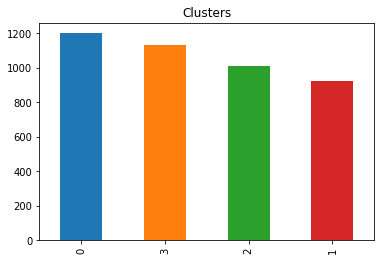

In [44]:
final_customer_df["clusters"].value_counts().plot.bar(title= 'Clusters')
import collections
print(collections.Counter(clusters))

In [45]:
#statistical describe
print('statistical describe of cluster 0:')
print(final_customer_df[(final_customer_df['clusters'] ==0) ].describe())
print('statistical describe of cluster 1:')
print(final_customer_df[(final_customer_df['clusters'] ==1) ].describe())
print('statistical describe of cluster 2:')
print(final_customer_df[(final_customer_df['clusters'] ==2) ].describe())
print('statistical describe of cluster 3:')
print(final_customer_df[(final_customer_df['clusters'] ==3) ].describe())

statistical describe of cluster 0:
             index    recency_    total_price       Count_  clusters  \
count  1200.000000  1200.00000    1200.000000  1200.000000    1200.0   
mean   2075.240000    51.51250    1354.884069     2.646667       0.0   
std    1241.674518    43.27018    5198.656145     1.002161       0.0   
min       2.000000    -1.00000     322.410000     1.000000       0.0   
25%     969.000000    17.00000     662.537500     2.000000       0.0   
50%    2085.500000    40.00000     912.685000     3.000000       0.0   
75%    3082.750000    76.25000    1324.585000     3.000000       0.0   
max    4338.000000   234.00000  168472.500000     5.000000       0.0   

              Rank  
count  1200.000000  
mean   1689.557083  
std     560.893196  
min       4.000000  
25%    1298.750000  
50%    1735.000000  
75%    2143.250000  
max    3099.000000  
statistical describe of cluster 1:
             index    recency_  total_price      Count_  clusters         Rank
count   921.0

Text(0.5, 0, 'monetary')

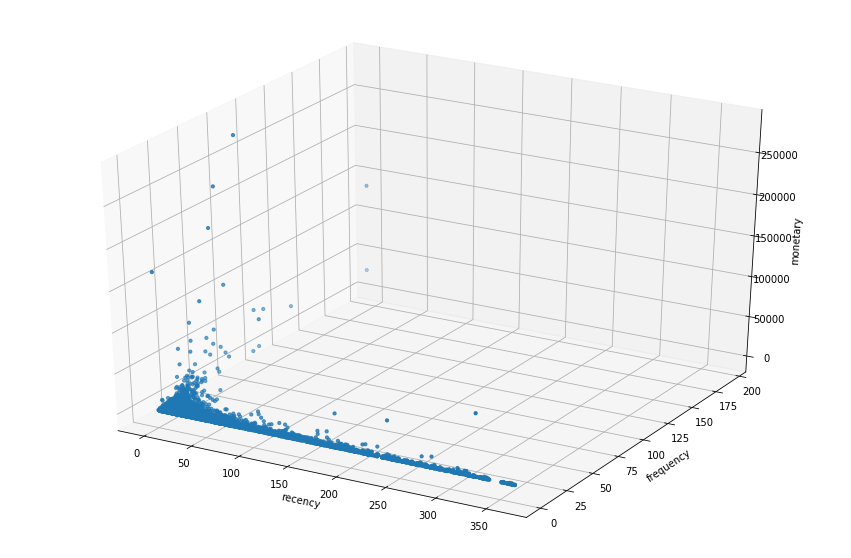

In [47]:
from math import log
#Applying log transformations
#final_customer_df['log_Recency'] = recency_df['Recency'].apply(math.log)
#final_customer_df['log_Frequency'] = frequency_df['Count'].apply(math.log)
#final_customer_df['log_Monetary'] = monetary_df['total_price'].apply(math.log)

#plot RFM in 3D
#from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(final_customer_df.recency_, final_customer_df.Count_, final_customer_df.total_price, s=10)

ax.set_xlabel('recency')
ax.set_ylabel('frequency')
ax.set_zlabel('monetary')


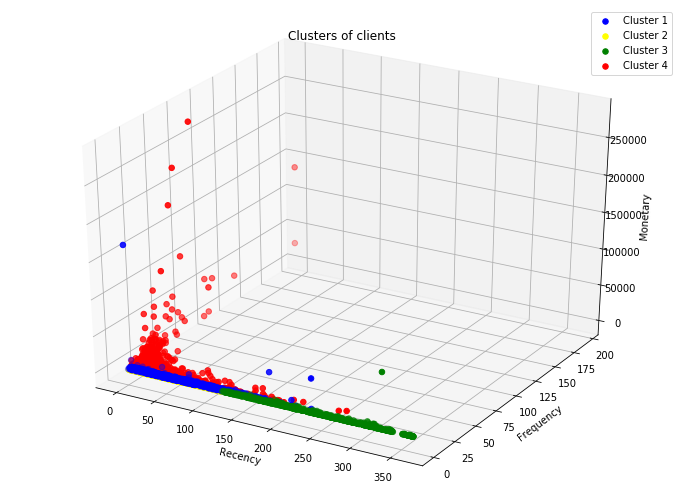

In [48]:
fig = plt.figure(figsize=(12,9))
dx = fig.add_subplot(111, projection='3d')
colors = ['blue', 'yellow', 'green', 'red']

for i in range(0,4):
    dx.scatter(final_customer_df[final_customer_df.clusters == i].recency_,
               final_customer_df[final_customer_df.clusters == i].Count_, 
               final_customer_df[final_customer_df.clusters == i].total_price, 
               c = colors[i], 
               label = 'Cluster ' + str(i+1), 
               s=30)

dx.set_title('Clusters of clients')
dx.set_xlabel('Recency')
dx.set_ylabel('Frequency')
dx.set_zlabel('Monetary')
dx.legend()

In [283]:
import math
#Applying log transformations
final_customer_df['log_Recency'] = final_customer_df["recency_"].apply(math.log)
final_customer_df['log_Frequency'] = final_customer_df["Count_"].apply(math.log)
final_customer_df['log_Monetary'] = final_customer_df["total_price"].apply(math.log)

#plot RFM in 3D
#from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(final_customer_df.log_Recency, final_customer_df.log_Frequency, final_customer_df.log_Monetary, s=10)

ax.set_xlabel('recency')
ax.set_ylabel('frequency')
ax.set_zlabel('monetary')


ValueError: math domain error

---

### End Note
The higher RFM of the customer, the higher lifetime value for the customer is. We can use the calculated table, final_customer_df, to segment our customers by different RFM.

Reference
* http://www.eightleaves.com/2011/01/using-rfm-to-identify-your-best-customers
* https://en.wikipedia.org/wiki/RFM_(customer_value)
* https://medium.com/@tomar.ankur287/customer-segmentation-using-rfm-analysis-in-python-bb6f1bd2fce5